# **Review of Ivado-Mila Deep Learning School Spring 2021**

**Author** : Joris Christopher Tabeu

In [1]:
!pip3 install torch torchvision matplotlib
!pip3 install --upgrade pillow==8.1.0

Requirement already up-to-date: pillow==8.1.0 in /usr/local/lib/python3.7/dist-packages (8.1.0)


Loading of all the libraries we need to do the work

In [2]:
import importlib
required_libraries = ['torch', 'torchvision', 'PIL', 'matplotlib', 'numpy']
for lib in required_libraries:
    if importlib.util.find_spec(lib) is None:
        print("%s unavailable" % lib)

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

use_gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if use_gpu else "cpu")

print("Torch version: ", torch.__version__)
print("GPU Available: {}".format(use_gpu))

Torch version:  1.9.0+cu102
GPU Available: True


Fix the seed for the different librairies

In [4]:
seed = 1234
np.random.seed(seed) # Set the random seed of numpy for the data split.
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

We will use the CIFAR-10 dataset.
In this section, we provide a function for downloading the CIFAR-10 dataset. It takes as input two arguments:
- **path**: the directory where the downloaded dataset will be saved.
- **train_flag**: boolean flag indicating whether to download data from the training set (`train_flag=True`) or the test set (`train_flag=False`).

It returns two elements, namely:
- **imgs**: NumPy array representing the downloaded images of size N x 32 x 32 x 3 where N is the number of images.
- **labels**: list of N (indexed-)classes, each associated with a single image.

In [5]:
def download_CIFAR10(path, train_flag):
  """
  Args:
     path: the directory where the dowloaded dataset will be saved.
     train_flag: if `True`, download data from training set, otherwise
        download from test set.
        
  Return:
     A tuple of two elements (imgs, labels) where
        imgs: a numpy array of shape N x 32 x 32 x 3 where N is the number of images.
        labels: list of N (indexed-)classes, each  associated with a single image.
  
  """
  dataset = torchvision.datasets.CIFAR10(
      root=path, train=train_flag, download=True
  )
  imgs, labels = dataset.data, dataset.targets
  return imgs, labels

#### Download the CIFAR-10 dataset and retrieve the training set & test set

In [6]:
imgs, labels = download_CIFAR10('./', True)


Extracting ./cifar-10-python.tar.gz to ./


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
test_imgs, test_labels = download_CIFAR10('./', False)

Files already downloaded and verified


### Data split

In the previous section, we provide functions to download the **train** and **test** datasets. Usually, we need three sets of data in a ML project: train, **validation**, and test sets. Unfortunately, the CIFAR-10 dataset does not contain a preprocessed validation set; therefore, we need to create a **custom** one by sampling from the **training** set.

In this section, we provide a function for creating a validation set from the original training set. It takes as input five arguments:
- **imgs**: NumPy array representing the image set from which the partitioning is made.
- **labels**: labels associated with the provided image set.
- **valid_ratio** (optional): a proportion of the data that will be used for the validation set. Default: `0.3`.
- **shuffle** (optional): whether or not the data need to be shuffled before the partitioning is made. Default: `True`.
- **seed** (optional): the seed of the random generator. Default: `1234`.

It provides as output 4 elements, which are:
- **train_imgs**: NumPy array representing the images of the training set after the splitting is done.
- **train_labels**: labels associated with the images of the training set.
- **valid_imgs**: NumPy array representing the images of the validation set after the splitting is done.
- **valid_labels**: labels associated with the images of the validation set.

In [9]:
def partition_dataset(imgs, labels, valid_ratio=0.3, shuffle=True, seed=1234):
  """
  Args:
     imgs: numpy array representing the image set from which 
        the partitioning is made.
     labels: the labels associated with the provided images.
     valid_ratio (optional): the proportion of the data that will be used in
        the validation set. Default: 0.3.
     shuffle (optional): whether or not to shuffle the data. Default: True.
     seed (optional): the seed of the numpy random generator: Default: 1234.
        
  Return:
     A tuple of 4 elements (train_imgs, train_labels, valid_imgs, valid_labels)
     where:
        train_imgs: a numpy array of images for the training set.
        train_labels: labels associated with the images in the training set.
        valid_imgs: a numpy array of images for the validation set.
        valid_labels: labels associated with the images in the validation set.
  
  """
  if shuffle:
    np.random.seed(seed)  # Set the random seed of numpy.
    indices = np.random.permutation(imgs.shape[0])
  else:
    indices = np.arange(imgs.shape[0])
  
  train_idx, valid_idx = np.split(
      indices, 
      [int((1.0 - valid_ratio)*len(indices))]
  )
  train_imgs, valid_imgs = imgs[train_idx], imgs[valid_idx]
  labels = np.array(labels)
  train_labels, valid_labels = labels[train_idx].tolist(), labels[valid_idx].tolist()
  return train_imgs, train_labels, valid_imgs, valid_labels
  

Generate the custom training and validation sets by using partition_dataset with the default parameters.

In [10]:
train_imgs, train_labels, valid_imgs, valid_labels = partition_dataset(imgs=imgs, labels=labels)

### Data visualization

Before training any model, you should do some sanity checks of the data to ensure that the retrieval and the split were correctly done.

This section provides some functions for visualizing image data and computing the label distribution within a dataset.

In [11]:
import matplotlib.pyplot as plt


def plot_image(img):
  """
  Plot a single image.
  
  Args:
     img: image to be plotted.
     
  """
  plt.imshow(img)
  plt.show()

  
def plot_random_images(imgs, n):  
  """
  Randomly sample n images from an image set and plot them in a grid.
  
  Args:
     imgs: collection of images from which sampling will be made.
     n: the number of images to be sampled.
     
  """
  sampled_indices = np.random.choice(imgs.shape[0], n, False)
  sampled_images = imgs[sampled_indices]
  
  sampled_images = np.transpose(sampled_images, (0, 3, 1, 2))
  sampled_tensor = torch.Tensor(sampled_images)
  
  grid_tensor = torchvision.utils.make_grid(
      sampled_tensor, normalize=True, value_range=(0, 255)
  )
  grid_tensor = np.transpose(grid_tensor.numpy(), (1, 2, 0))
  
  plot_image(grid_tensor)
  
  
def plot_dataset_histogram(labels, title='Label distribution', rel_freq=False):
  """
  Plot the histogram/distribution of the labels within a dataset.
  
  Args:
     labels: collection of labels from which the distribution is computed.
     title: the title of the histogram.
     rel_freq: if true, the histogram is normalized to show relative frequencies
               otherwise, it shows the frequencies.
     
  """
  _ = plt.hist(labels, bins=np.arange(11)-0.5, rwidth=0.85, density=rel_freq)
  plt.title(title)
  plt.xlabel('Label')
  if rel_freq:
    plt.ylabel('Relative frequency')
  else:
    plt.ylabel('Frequency')
  plt.xticks(np.arange(10))
  plt.show()


Use the previously defined functions to visualize samples from training and validation sets. Also, compute the label distributions for these two sets. Comment on your observations.

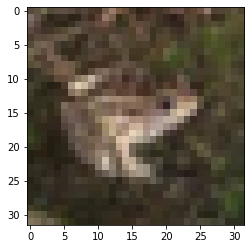

In [12]:
plot_image(imgs[22])

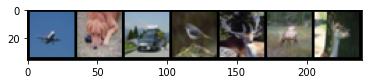

In [13]:
plot_random_images(imgs=imgs, n=7)

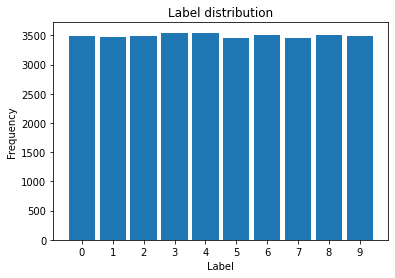

In [14]:
plot_dataset_histogram(labels=train_labels)

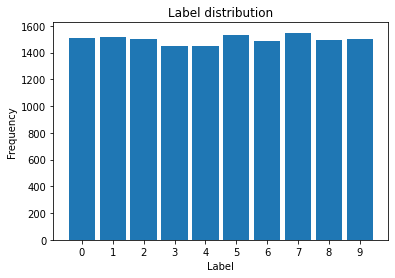

In [15]:
plot_dataset_histogram(labels=valid_labels)

### Shuffling data

It is essential to **shuffle** the dataset before partitioning it into training, validation and test sets to remove spurious correlations due to the ordering. Remember the dataset should be **independently** and identically distributed.

The CIFAR-10 dataset downloaded at the beginning of this tutorial was already shuffled. To visualize the importance of shuffling, suppose we observe the following label distributions after splitting.

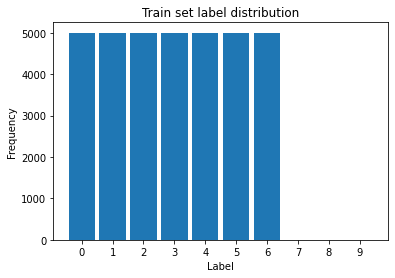

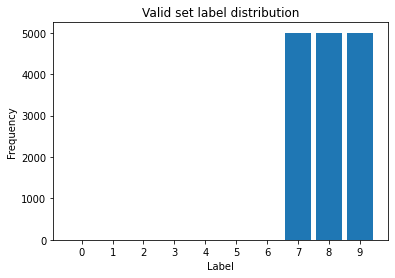

In [16]:
sorted_idx = np.argsort(labels)
sorted_imgs = imgs[sorted_idx]
sorted_labels = [labels[i] for i in sorted_idx]

_, sorted_train_labels, _, sorted_valid_labels = partition_dataset(sorted_imgs, sorted_labels,
                                                                   valid_ratio=0.3, shuffle=False, seed=seed)
plot_dataset_histogram(sorted_train_labels, 'Train set label distribution')
plot_dataset_histogram(sorted_valid_labels, 'Valid set label distribution')

Below, we shuffle the data and observe that the labels are evenly distributed in the training and validation sets.

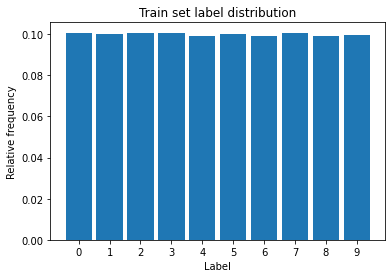

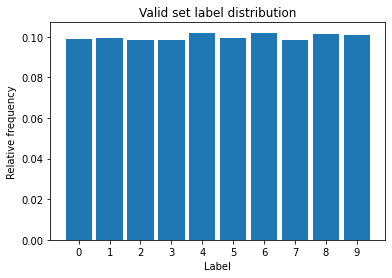

In [17]:
_, shuffled_train_labels, _, shuffled_valid_labels = partition_dataset(
    sorted_imgs, sorted_labels, valid_ratio=0.3, shuffle=True, seed=seed
)

plot_dataset_histogram(
    shuffled_train_labels, 'Train set label distribution', rel_freq=True)

plot_dataset_histogram(
    shuffled_valid_labels, 'Valid set label distribution', rel_freq=True)

### Dataloaders

Since deep learning requires heavy data transformations, we want tools that efficiently **transform**, **shuffle**, and **batch** our datasets with the option to use multiprocessing workers. A dataloader is an optimized data iterator that provides all these features.

In [18]:
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader


def create_dataset(images, labels, n):
  """
  Slice the first n images/labels and create a torch.utils.data.DataLoader.
  
  Args:
     images: numpy array of images.
     labels: list of labels associated with the images.
     n: the number of images/labels to slice.
        
  Return:
     A torch.utils.data.TensorDataset to be used with a torch.utils.data.DataLoader.
     
  """
  imgs = torch.tensor(images[:n], dtype=torch.float)
  labels = torch.tensor(labels[:n], dtype=torch.long)
  dataset = TensorDataset(imgs, labels)
  return dataset


n = 100
batch_size = 32
train_dataset = create_dataset(train_imgs, train_labels, n)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, drop_last=False, shuffle=True)

epochs = 2
for epoch in range(epochs):
  print('Epoch {}/{}:'.format(epoch+1, epochs))
  for i, (x, y) in enumerate(train_dataloader):
    print('   batch {}/{} of {} examples.'.format(i+1, int(np.ceil(n/batch_size)), y.size(0)))

Epoch 1/2:
   batch 1/4 of 32 examples.
   batch 2/4 of 32 examples.
   batch 3/4 of 32 examples.
   batch 4/4 of 4 examples.
Epoch 2/2:
   batch 1/4 of 32 examples.
   batch 2/4 of 32 examples.
   batch 3/4 of 32 examples.
   batch 4/4 of 4 examples.


Having 4 examples in the last mini-batch instead of 32 gives more weight to these 4 examples than the other examples. In practice, if we shuffle the training set at each epoch, we mitigate this bias since different examples will have the chance to be in the last mini-batch.

### Training with neural networks

The first method, `training_on_dataset`, trains a model on a given dataset. It takes as input the following arguments and returns a **trained model**:
- **imgs**: images the model will be trained on.
- **labels**: labels associated with the provided images.
- **eval_imgs**: images to evaluate the model.
- **eval_labels**: labels associated with the images used to evaluate the model.
- **epochs**: number of epochs during the training (number of times to loop over the whole set of images/labels).
- **batch_size** (optional): size of a mini-batch. Default: `8`.
- **lr** (optional): learning rate. Default: `1e-3`.
- **seed** (optional): the seed of the random generator. Default: `1234`.
- **transformations** (optional): transformations to apply to the images during the training process. Default: `None`.
- **label_weights** (optional): importance weights associated with each label. Default: `None` (all labels are treated equally).
- **metrics** (optional): metrics to monitor during training. Default: `None`.

The second one, `evaluate_classes`, evaluates a trained model on a given dataset. It takes as input the following arguments and returns the **evaluation performance**:
- **net**: the trained model to be evaluated.
- **imgs**: images the model will be evaluated on.
- **labels**: ground truth labels associated with the provided images for performance computation.
- **batch_size** (optional): size of a mini-batch. Default: `8`.
- **metrics** (optional): performance metrics to compute. Default: `None`.

In [19]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sklearn.metrics as metrics


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
classe_names = (
    'plane', 'car', 'bird', 'cat', 'deer', 
    'dog', 'frog', 'horse', 'ship', 'truck'
)


def accuracy(y_true, y_pred):
  """
  Compute the accuracy score.
  
  Args:
     y_true: ground truth labels.
     y_pred: predicted labels by a classifier.
     
  Return:
     Accuracy score.
     
  """
  return metrics.accuracy_score(y_true, y_pred)


def f1_score(y_true, y_pred):
  """
  Compute the F1 score.
  
  Args:
     y_true: ground truth labels.
     y_pred: predicted labels by a classifier.
     
  Return:
     F1 score.
     
  """
  return metrics.f1_score(y_true, y_pred, average='macro')


def plot_metric(train_values, valid_values, name=''):
  """
  Plot the values of a given metric on training and validation sets.
  
  Args:
     train_values: values of the metric on the training set. 
     valid_values: values of the metric on the validation set.
     name: name of the metric.
  """
  x = range(len(train_values))
  plt.plot(x, train_values, label='train')
  plt.plot(x, valid_values, label='valid')
  plt.title(name)
  plt.legend()
  plt.show()
  

class AugmentBasedDataset(Dataset):
  """Encapsulated dataset for data augmentation."""

  def __init__(self, dataset, transform=None):
    """
    Args:
        dataset: dataset on which to perform data augmentation.
        transform (callable, optional): optional transform to be applied
            on a sample.

    """
    self.dataset = dataset
    self.transform = transform

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    img, label = self.dataset[idx]
    if self.transform:
        img = self.transform(img)
    return img, label


In [20]:
class Net(nn.Module):
  """Basic CNN used for image classification."""
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 5 * 5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

### How much training data is needed ?

In [21]:
#@title Auxiliary functions for training and evaluating the model
def training_on_dataset(imgs, labels, eval_imgs, eval_labels,
                        epochs, batch_size=8, lr=1e-3,
                        seed=1234, transformations=None, label_weights=None,
                        metrics=None, verbose=True):
  """Black box function to train a neural network on CIFAR-10 dataset."""
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  np.random.seed(seed)
  
  # Train data.
  train_imgs = ((imgs/255.0) - 0.5) * 2.0  # Normalize to [-1, 1].
  train_imgs = np.transpose(train_imgs, (0, 3, 1, 2))
  train_labels = np.array(labels)
  
  train_dataset = TensorDataset(
      torch.from_numpy(train_imgs).float(), 
      torch.from_numpy(train_labels).long()
  )
  train_dataset = AugmentBasedDataset(train_dataset, transformations)
  train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

  # Eval data.
  eval_imgs = ((eval_imgs/255.0) - 0.5) * 2.0 # Normalize to [-1, 1]
  eval_imgs = np.transpose(eval_imgs, (0, 3, 1, 2))
  eval_labels = np.array(eval_labels)
  
  eval_dataset = TensorDataset(
      torch.from_numpy(eval_imgs).float(), 
      torch.from_numpy(eval_labels).long()
  )
  eval_dataloader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False)

  net = Net()
  net = net.to(device)
  if label_weights is not None:
    label_weights = torch.tensor(label_weights).float()
    label_weights = label_weights.to(device)
  criterion = nn.CrossEntropyLoss(weight=label_weights)
  optimizer = optim.Adam(net.parameters(), lr=lr)
  
  train_loss_values = []
  eval_loss_values = []
  train_metric_values = None
  eval_metric_values = None
  
  if metrics is not None:
    if isinstance(metrics, dict):
      train_metric_values = {metric: [] for metric in metrics.keys()}
      eval_metric_values = {metric: [] for metric in metrics.keys()}
    elif isinstance(metrics, (list, tuple)):
      train_metric_values = {metric: [] for metric in range(len(metrics))}
      eval_metric_values = {metric: [] for metric in range(len(metrics))}
    else:
      metrics = [metrics]
      train_metric_values = {metric: [] for metric in range(len(metrics))}
      eval_metric_values = {metric: [] for metric in range(len(metrics))}

  for epoch in range(epochs):  # Loop over the dataset.
    net.train()
    running_loss = 0.0
    n_update = 0
    y_true = []
    y_pred = []
    for data in train_dataloader:
      # data is a tuple of (inputs, targets).
      inputs, targets = data
      
      if targets.numel() > 1:
        y_true.extend(targets.flatten().tolist())
      else:
        y_true.append(targets.flatten().tolist())
      
      inputs = inputs.to(device)
      targets = targets.to(device)       

      # Reset the parameter gradients.
      optimizer.zero_grad()

      # Forward + backward + optimize.
      outputs = net(inputs)
      loss = criterion(outputs, targets)
      loss.backward()
      optimizer.step()
      
      # Predict label.
      _, predicted = torch.max(outputs, 1)
      if predicted.numel() > 1:
        y_pred.extend(predicted.flatten().tolist())
      else:
        y_pred.append(predicted.flatten().tolist())

      running_loss += loss.item()
      n_update += 1

    # Save and print statistics at the end of each training epoch.
    train_loss = running_loss / n_update
    train_loss_values.append(train_loss)
    eval_loss, eval_true, eval_pred = evaluate_during_training(net, criterion, eval_dataloader)
    eval_loss_values.append(eval_loss)
    
    if metrics is not None:
      for metric in metrics.keys():
        train_metric_values[metric].append(metrics[metric](y_true, y_pred))
        eval_metric_values[metric].append(metrics[metric](eval_true, eval_pred))
  
    if verbose:
      print('[Epoch {}/{}] Training loss: {:.3f} | Validation loss: {:.3f}' 
            .format(epoch + 1, epochs, train_loss, eval_loss)
      )
    running_loss = 0.0
    n_update = 0
    y_true = []
    y_pred = []
  
  if verbose:
    plot_metric(train_loss_values, eval_loss_values, 'Loss')
    if metrics is not None:
      for metric in metrics.keys():
        plot_metric(train_metric_values[metric], eval_metric_values[metric], metric)
  
  return net


def evaluate_during_training(net, criterion, dataloader):
  net.eval()
  running_loss = 0.0
  n_update = 0
  y_true = []
  y_pred = []
  for data in dataloader:
    inputs, targets = data
    if targets.numel() > 1:
      y_true.extend(targets.flatten().tolist())
    else:
      y_true.append(targets.flatten().tolist())
    inputs = inputs.to(device)
    targets = targets.to(device) 
    with torch.no_grad():
      outputs = net(inputs)
      loss = criterion(outputs, targets)  
      _, predicted = torch.max(outputs, 1)
      if predicted.numel() > 1:
        y_pred.extend(predicted.flatten().tolist())
      else:
        y_pred.append(predicted.flatten().tolist())
      running_loss += loss.item()
      n_update += 1
  eval_loss = running_loss / n_update
  return eval_loss, y_true, y_pred


def evaluate_classes(net, imgs, labels, batch_size=8, metrics=None, verbose=True):
  """Black box function to evaluate a neural network on CIFAR-10 dataset."""
  normalized_imgs = ((imgs/255.0) - 0.5) * 2.0 # Normalize to [-1, 1]
  normalized_imgs = np.transpose(normalized_imgs, (0, 3, 1, 2))
  arr_labels = np.array(labels)
  
  dataset = TensorDataset(
      torch.from_numpy(normalized_imgs).float(), 
      torch.from_numpy(arr_labels).long()
  )
  dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
  
  net = net.to(device)
  correct = 0
  total = 0
  class_correct = [0.0] * 10
  class_total = [0.0] * 10
  class_acc = [0.0] * 10
  
  metric_values = None
  if not (metrics is None):
    if isinstance(metrics, dict):
      metric_values = {a: 0.0 for a in metrics.keys()}
    elif isinstance(metrics, (list, tuple)):
      metric_values = {a: 0.0 for a in range(len(metrics))}
    else:
      metrics = [metrics]
      metric_values = {a: 0.0 for a in range(len(metrics))}
  
  with torch.no_grad():
    y_true = []
    y_pred = []
    for data in dataloader:
      inputs, targets = data
      
      if targets.numel() > 1:
        y_true.extend(targets.flatten().tolist())
      else:
        y_true.append(targets.flatten().tolist())
        
      inputs = inputs.to(device)
      targets = targets.to(device)
      outputs = net(inputs)
      _, predicted = torch.max(outputs, 1)
      
      if predicted.numel()>1:
        y_pred.extend(predicted.flatten().tolist())
      else:
        y_pred.append(predicted.flatten().tolist())
      
      total += targets.size(0)
      correct += (predicted == targets).sum().item()
      
      c = (predicted == targets).squeeze()
      for i in range(targets.size(0)):
        label = targets[i]
        class_correct[label] += c[i].item()
        class_total[label] += 1
            
    if not (metric_values is None):
      for a in metric_values.keys():
        metric_values[a] = metrics[a](y_true, y_pred)
            
  global_acc = correct / max(total, 1.0)
  
  if verbose:
    if metrics is not None:
      print('Evaluation on the validation dataset:')
      for a in metric_values.keys():
        print('Metric {}: {:.0%}'.format(a, metric_values[a]))

  for i in range(10):
    class_acc[i] = class_correct[i] / max(class_total[i], 1.0)
    if verbose:
      print('Accuracy of {:<5s} ({}): {:.0%}'
            .format(classe_names[i], i, class_acc[i])
           )
    
  return global_acc, class_acc


### Training with only 1% of the data

Let's start by considering only 1% of the training set. The following method allows selecting a subset of data from a given dataset. It takes as input five arguments:
- **imgs**: NumPy array representing the image set from which the selection is made.
- **labels**: labels associated with the provided image set.
- **ratio** (optional): percentage of data that will be selected. Default: `0.1`.
- **shuffle** (optional): whether or not the data need to be shuffled before the selection is made. Default: `True`.
- **seed** (optional): seed of the random generator: Default: `1234`.

It provides as output 2 elements:
- **select_imgs**: NumPy array of the selected images.
- **select_labels**: labels associated with the selected images.

In [22]:
def select_subset_from_dataset(imgs, labels, ratio=0.1, shuffle=True, seed=1234):
  """
  Args:
     imgs: numpy array representing the image set from which 
        the selection is made.
     labels: the labels associated with the provided images.
     ratio (optional): percentage of data to be selected. Default: 0.1.
     shuffle (optional): Whether or not to shuffle the data. Default: True.
     seed (optional): seed of the numpy random generator: Default: 1234.
        
  Return:
     A tuple of 2 elements (select_imgs, select_labels)
     where:
        select_imgs: a numpy array of the selected images.
        select_labels: labels associated with the selected images.
      
  """
  if shuffle:
    np.random.seed(seed)  # Set the random seed of numpy.
    indices = np.random.permutation(imgs.shape[0])
  else:
    indices = np.arange(imgs.shape[0])
  idx, _ = np.split(indices, [int(ratio*len(indices))])
  select_imgs = imgs[idx]
  labels = np.array(labels)
  select_labels = labels[idx].tolist()
  return select_imgs, select_labels

We create a new training set that contains only 1% of the original training set.

In [23]:
train_1percent_imgs, train_1percent_labels  = select_subset_from_dataset(
    train_imgs, train_labels, ratio=0.01
)

Train a model on 1% of the training set and evaluate its performance on the validation set. Use the following values for this experiment:
- **epochs**: `50`.
- **batch_size**: `32`.
- **metrics**: `{'Accuracy': accuracy}`.
- **eval_imgs**: `valid_imgs`.
- **eval_labels**: `valid_labels`.

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[Epoch 1/50] Training loss: 2.304 | Validation loss: 2.291
[Epoch 2/50] Training loss: 2.257 | Validation loss: 2.251
[Epoch 3/50] Training loss: 2.160 | Validation loss: 2.173
[Epoch 4/50] Training loss: 2.038 | Validation loss: 2.109
[Epoch 5/50] Training loss: 1.955 | Validation loss: 2.069
[Epoch 6/50] Training loss: 1.877 | Validation loss: 2.085
[Epoch 7/50] Training loss: 1.838 | Validation loss: 2.012
[Epoch 8/50] Training loss: 1.772 | Validation loss: 2.027
[Epoch 9/50] Training loss: 1.708 | Validation loss: 2.089
[Epoch 10/50] Training loss: 1.667 | Validation loss: 2.009
[Epoch 11/50] Training loss: 1.632 | Validation loss: 2.049
[Epoch 12/50] Training loss: 1.581 | Validation loss: 2.085
[Epoch 13/50] Training loss: 1.556 | Validation loss: 2.073
[Epoch 14/50] Training loss: 1.515 | Validation loss: 2.027
[Epoch 15/50] Training loss: 1.426 | Validation loss: 2.084
[Epoch 16/50] Training loss: 1.358 | Validation loss: 2.122
[Epoch 17/50] Training loss: 1.257 | Validation l

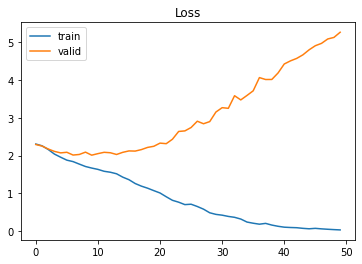

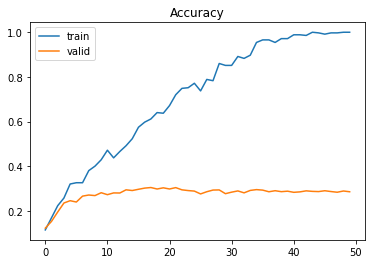

Evaluation on the validation dataset:
Metric Accuracy: 29%
Accuracy of plane (0): 44%
Accuracy of car   (1): 33%
Accuracy of bird  (2): 22%
Accuracy of cat   (3): 27%
Accuracy of deer  (4): 27%
Accuracy of dog   (5): 14%
Accuracy of frog  (6): 35%
Accuracy of horse (7): 28%
Accuracy of ship  (8): 22%
Accuracy of truck (9): 33%


In [24]:
# training on selected data
model = training_on_dataset(train_1percent_imgs, train_1percent_labels, valid_imgs, valid_labels,
                    epochs = 50, batch_size=32, lr=1e-3,
                    seed=1234, transformations=None, label_weights=None,
                    metrics={'Accuracy': accuracy}, verbose=True) # To complete.

# evaluate the trained model on the validation dataset
_ = evaluate_classes(model, valid_imgs, valid_labels, batch_size=32, metrics={'Accuracy': accuracy}, verbose=True) # To complete.


### Performance as a function of the dataset size

In the following, We train the same model on various ratios of the training set while keeping the validation set fixed. We want to observe the impact of using larger training sets.

The following function performs this study given a list of ratio values. It takes as arguments:
- **ratio_list**: list of ratio numbers to be considered in the study.
- **epochs** (optional): number of training epochs. Default: `5`.
- **seed** (optional): seed of the random generator: Default: `1234`.

This function generates a plot showing the accuracy as a function of the ratio of data used for training the model.

It is important to note that by fixing the number of epochs, we perform more parameter updates as the training set's size increases. Hence, the overall study is not entirely comparable. However, since the accuracy does not decrease over time in this example, we can still observe the typical phenomenon associated with increasing the training set sizes.

In [25]:
def performance_study(ratio_list, epochs=5, seed=1234):
  """
  Args:
     ratio_list: list of ratio numbers to be considered.
     epochs (optional): number of training epochs. Default: 5.
     seed (optional): seed of the numpy random generator: Default: 1234.
        
  Return:
     This method does not return anything, but it generates a plot.
      
  """
  results = []
  for ratio in ratio_list:
    select_imgs, select_labels = select_subset_from_dataset(
        train_imgs, train_labels, ratio
    )
    trained_model = training_on_dataset(
        select_imgs, select_labels, valid_imgs, valid_labels,
        epochs=epochs, batch_size=32,
        seed=seed, verbose=False
    )
    acc, _ = evaluate_classes(
        trained_model, valid_imgs, valid_labels, batch_size=32,
        verbose=False
    )
    results.append(acc)
  
  print('Best accuracy: {:.0%}'.format(max(results)))
  plt.plot(ratio_list, results)
  plt.title('Model performance on validation set')
  plt.xlabel('Training set ratio')
  plt.ylabel('Accuracy')
  plt.show()


Evaluate the performance using the following ratios: 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 1.0.

Best accuracy: 60%


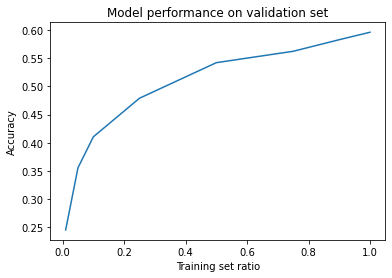

In [26]:
ratio_list = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 1.0]
performance_study(ratio_list)


Assume that we only have access to 30% of the original training dataset. Train a model with this subset of data and evaluate it on the validation dataset. As the number of examples increases in the training set, we may consider increasing the number of epochs while keeping in mind the overfitting problem. For this exercise, we will use the following arguments:
- **epochs**: `15`.
- **batch_size**: `32`.
- **metrics**: `{'Accuracy': accuracy}`

[Epoch 1/15] Training loss: 1.948 | Validation loss: 1.762
[Epoch 2/15] Training loss: 1.623 | Validation loss: 1.575
[Epoch 3/15] Training loss: 1.499 | Validation loss: 1.480
[Epoch 4/15] Training loss: 1.410 | Validation loss: 1.435
[Epoch 5/15] Training loss: 1.334 | Validation loss: 1.437
[Epoch 6/15] Training loss: 1.265 | Validation loss: 1.385
[Epoch 7/15] Training loss: 1.206 | Validation loss: 1.384
[Epoch 8/15] Training loss: 1.137 | Validation loss: 1.404
[Epoch 9/15] Training loss: 1.095 | Validation loss: 1.377
[Epoch 10/15] Training loss: 1.011 | Validation loss: 1.456
[Epoch 11/15] Training loss: 0.969 | Validation loss: 1.425
[Epoch 12/15] Training loss: 0.898 | Validation loss: 1.476
[Epoch 13/15] Training loss: 0.838 | Validation loss: 1.518
[Epoch 14/15] Training loss: 0.779 | Validation loss: 1.604
[Epoch 15/15] Training loss: 0.723 | Validation loss: 1.637


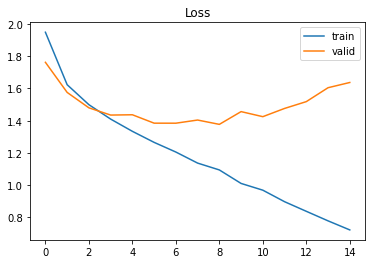

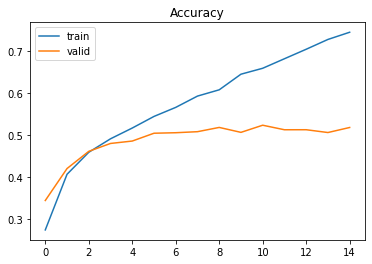

Evaluation on the validation dataset:
Metric Accuracy: 52%
Accuracy of plane (0): 57%
Accuracy of car   (1): 68%
Accuracy of bird  (2): 33%
Accuracy of cat   (3): 42%
Accuracy of deer  (4): 40%
Accuracy of dog   (5): 41%
Accuracy of frog  (6): 60%
Accuracy of horse (7): 58%
Accuracy of ship  (8): 70%
Accuracy of truck (9): 49%


In [27]:
# select the data
train_30percent_imgs, train_30percent_labels = select_subset_from_dataset(
    train_imgs, train_labels, ratio=0.3
) # To complete.

# train on the selected data
model = training_on_dataset(train_30percent_imgs, train_30percent_labels, valid_imgs, valid_labels,
                    epochs = 15, batch_size=32, lr=1e-3,
                    seed=1234, transformations=None, label_weights=None,
                    metrics={'Accuracy': accuracy}, verbose=True) # To complete. # To complete.

# evaluate the trained model on the validation dataset
_ = evaluate_classes(model, valid_imgs, valid_labels, batch_size=32, metrics={'Accuracy': accuracy}, verbose=True) # To complete.
